**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [85]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [86]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [126]:
df = pd.read_csv("/content/drive/MyDrive/NIDA/CRM/Voice of customer/Wongnai Reviews - Small.csv")

In [127]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [128]:
embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [129]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

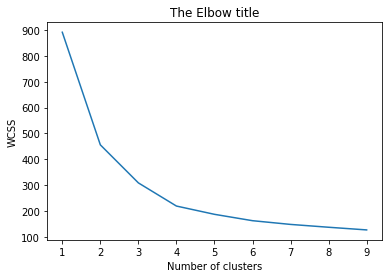

In [130]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [131]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [163]:
df.groupby(['KMeans ID']).count()

,Review ID,Review
KMeans ID,,
0,48,48
1,100,100
2,69,69
3,83,83


In [132]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [133]:
df_kmeans

,KMeans ID,texts
0,0,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [134]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [135]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [136]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [137]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [138]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [139]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [140]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน', 'นขา', 'กก', 'เค', 'เด', 'เม', 'หลาน', 'ไหม', 'าน', 'ไร้', 'เป็ร้าน', 'อย่า', 'เกริ่น', 'ๆๆ']
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "อเมซอน"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [141]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [142]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 6), (..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, Arto...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (ซอย, ..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี..."


In [143]:
uniqueWords = set(df_kmeans['texts_tokenized'][0]).union(set(df_kmeans['texts_tokenized'][1])).union(set(df_kmeans['texts_tokenized'][2])).union(set(df_kmeans['texts_tokenized'][3]))

In [144]:
numOfWords_list = []

for i in range(0, 4):
  numOfWords = dict.fromkeys(uniqueWords, 0)
  for word in df_kmeans['texts_tokenized'][i]:
    numOfWords[word] += 1
  numOfWords_list.append(numOfWords)

In [145]:
len(numOfWords_list)

4

In [146]:
numOfWords = pd.DataFrame(numOfWords_list)
numOfWords

,เลี้ยว,กาแฟร้อน,เครื่องดื่ม,เร้า,ลอง,กลาง,เพรา,ด่าน,ห้องเรียน,ยม,ชั้นเดียว,ช็อคโกแล็ต,ยั่วยวน,สลัว,หน้า,ฝรั่ง,ชั้น,เรื่อง,โต๊ะ,แวะ,ตา,ขนม,มัฟฟิ่น,แหม,อบ,แดด,แตงโม,สวัสดี,ชาวเหนือ,น้องสาว,สุขาภิบาล,ยย,ร้า,แหวว,หา,ขนาน,แมคโคร,ต่อให้,ซุ้ม,เดินเล่น,...,พัก,จรัญ,รู้สึก,นั่,บร,ฝรั่งเศส,อ้อ,ปรากฎ,บ้,กลิ่น,เร,เดอะ,ขั้นตอน,สมราคา,ซา,มด,เลี้ยง,ไพ,OISHIbuffet,มาหา,จ,ด้ว,คุ้ม,แกง,nn------------,คนแนะนำ,ร้,เนื่องด้วย,ห,รู้จัก,ร้านอาหาร,ก่อนอื่น,ยิ่,ลงมา,(,Starbucksn,ชา,โจ%,ชล,เผา
0,0,0,4,1,3,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,3,0,1,1,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,18,1,0,0
1,0,1,1,2,3,0,0,0,1,0,0,1,1,0,0,0,4,1,3,6,1,1,1,0,0,1,0,4,0,0,0,0,2,1,3,0,0,0,0,0,...,3,0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,1,0,0,0,2,0,0,0,0,0,1,0,2,1,1,0,0,0,0,1,1,0,0,0
2,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,2,0,0,1,0,0,0,0,0,0,0,4,1,0,0,0,2,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,3,0,11,1,1,1,2,0,0,0,2,1
3,1,0,1,0,3,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,0,0,0,1,1,0,2,2,0,1,0,1,1,0,3,0,0,0,0,2,...,0,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,1,2,4,1,0,0,0,0,1,0,0,0


In [147]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

  
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict


def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [148]:
tf0 = computeTF(numOfWords_list[0], df_kmeans['texts_tokenized'][0])
tf1 = computeTF(numOfWords_list[1], df_kmeans['texts_tokenized'][1])
tf2 = computeTF(numOfWords_list[2], df_kmeans['texts_tokenized'][2])
tf3 = computeTF(numOfWords_list[3], df_kmeans['texts_tokenized'][3])

In [149]:
idfs = computeIDF(numOfWords_list)

In [150]:
tfidf0 = computeTFIDF(tf0, idfs)
tfidf1 = computeTFIDF(tf1, idfs)
tfidf2 = computeTFIDF(tf2, idfs)
tfidf3 = computeTFIDF(tf3, idfs)
list_tfidf = [tfidf0, tfidf1, tfidf2, tfidf3]

In [151]:
def dict_to_list(dic):
  list_of_tup = [(k, v) for k, v in dic.items()]
  return list_of_tup

In [152]:
list_tf_idf = [dict_to_list(x) for x in list_tfidf]

In [153]:
df_kmeans['text_tfidf'] = list_tf_idf

In [154]:
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count,text_tfidf
0,0,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 6), (...","[(เลี้ยว, 0.0), (กาแฟร้อน, 0.0), (เครื่องดื่ม,..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, Arto...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ทาน, 11), (ชอบ, ...","[(เลี้ยว, 0.0), (กาแฟร้อน, 0.00225047785896086..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กิน, 7), (อร่อย, 6), (ซอย, ...","[(เลี้ยว, 0.0), (กาแฟร้อน, 0.0), (เครื่องดื่ม,..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 10), (อร่อย, 9), (ทาน, 7), (ผม, 7), (รี...","[(เลี้ยว, 0.0030202491527666466), (กาแฟร้อน, 0..."


In [155]:
#show top keywords of each cluster = 0

text0 = list(df_kmeans['text_tfidf'][0])
topN_cluster0 = pd.DataFrame(text0, columns=['Text', 'TF_IDF'])
topN_cluster0 = topN_cluster0.sort_values(by = "TF_IDF", ascending=False)

In [156]:
topN_cluster0.head(10)

,Text,TF_IDF
592,ไข่มุก,0.065347
872,นม,0.065347
939,ชา,0.017435
721,ไต้หวัน,0.014003
788,ชาเขียว,0.009335
636,คุง,0.009335
710,นิว,0.009335
681,เติม,0.009335
537,Dakasi,0.009335
426,Ochaya,0.009335


In [157]:
#show top keywords of each cluster = 1

text1 = list(df_kmeans['text_tfidf'][1])
topN_cluster1 = pd.DataFrame(text1, columns=['Text', 'TF_IDF'])
topN_cluster1 = topN_cluster1.sort_values(by = "TF_IDF", ascending=False)

In [158]:
topN_cluster1.head(10)

,Text,TF_IDF
690,คาเฟ่,0.013503
174,ร้านกาแฟ,0.010274
842,แนว,0.009002
181,เบเกอรี่,0.009002
154,อเมซอน,0.009002
753,วัง,0.009002
684,พาย,0.009002
524,จิบ,0.006751
606,อย,0.006751
271,เค้ก,0.006751


In [159]:
#show top keywords of each cluster = 2

text2 = list(df_kmeans['text_tfidf'][2])
topN_cluster2 = pd.DataFrame(text2, columns=['Text', 'TF_IDF'])
topN_cluster2 = topN_cluster2.sort_values(by = "TF_IDF", ascending=False)

In [160]:
topN_cluster2.head(10)

,Text,TF_IDF
502,แซ่บ,0.012896
806,ดีล,0.009672
641,เป็ด,0.009672
213,ซอย,0.009672
614,เก่าแก่,0.009672
579,ยำ,0.009672
315,ราคา,0.008060
933,ร้านอาหาร,0.007359
418,หิน,0.006448
182,อิ่ม,0.006448


In [161]:
#show top keywords of each cluster = 3

text3 = list(df_kmeans['text_tfidf'][3])
topN_cluster3 = pd.DataFrame(text3, columns=['Text', 'TF_IDF'])
topN_cluster3 = topN_cluster3.sort_values(by = "TF_IDF", ascending=False)

In [162]:
topN_cluster3.head(10)

,Text,TF_IDF
499,คิว,0.009061
132,ดาว,0.006040
102,ไอติม,0.006040
757,ขนมปัง,0.006040
26,แตงโม,0.006040
98,ปีใหม่,0.006040
372,โอกาส,0.006040
601,ปากซอย,0.006040
733,เด็ด,0.006040
729,ศ,0.004530


##Summary

1. Cluster 0 -- เกี่ยวกับชานมไข่มุก Ochaya, Dakasi
2. Cluster 1 -- เกี่ยวกับร้านกาแฟ อเมซอน
3. Cluster 2 -- เกี่ยวกับร้านยำ แซ่บ
4. Cluster 3 -- เกี่ยวกับขนมไอติม แตงโม ปากซอย

